#  nn.BatchNorm基本使用方法

## nn.BatchNorm类介绍 

在PyTorch中，我们使用nn.Linear构建线性层，类似的，我们通过使用nn.BatchNorm类来构建BN层,进而可以进行Batch Normalization归一化操作，并且在后续操作过程中我们会发现，BN层和线性层之间由诸多相似之处。同时，出于对不同类型数据的不同处理需求，nn.BatchNorm1d类主要用于处理2d数据，nn.BatchNorm2d则主要用来处理3d数据。简单来说，目前我们所使用的面板数据(二维表格数据)都属于2d数据，使用nn.BatchNorm1d处理即可。而后续在处理图像数据时，则需要视情况和使用nn.BatchNorm2d类

In [1]:
# 查看帮助
nn.BatchNorm1d?

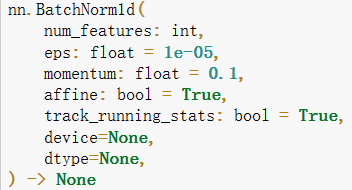

首先我们解释核心参数:

<li>num_features:输入数据的特征数量(假设为n),也就是前一层神经元数量或原始数据集特征数
量,根据此前的论述,BN层最终构建的是一个n*n的对角矩阵,对角线元素包含y,并且截距项为β;<br>
<li>eps:方差分母修正项,为了防止分母为0,一般取值为1e-5,也就是类默认值;<br>
<li>affine:是否进行仿射变换,需要注意的是,此时进行仿射变换时将使用无偏估计进行期望和方差的计算,并且初始条件下y=1,β=0,当参数取值为True时,会显式设置y和β参数并带入进行梯度下
降迭代计算,取值为False时,参数不显示,实际的数据归一化过程就是对原数据进行无偏估计下的Z-
Score变换。<br>
<li> momentum参数设置：关于momentum的设置,一般来说,为了尽可能获取到更加准确的训练集整体统计量,当每一个小批数据数据量比较小时,我们应该将历史数据比重调高,也就是降低momentum取值,以减少局部规律对获取总体规律的影响,当然,此时我们也需要增加遍历数据的次数epochs;而反之则可以考虑增大、momentum取值。<br>
<li>track_running_stats参数:对于BN来说，最后一个参数就是track_running_stats，默认取值为True。当此参数为True时，BN层会在每次迭代过程中会结合历史记录更新running_mean/var，当track_running_stats=False时，BN层将running_mean/var为None，并且在进行预测时会根据输入的小批数据进行均值和方差计算。在大多数情况下，并不推荐修改该参数的默认取值。 <br>

进行简单尝试

In [3]:
f = torch.arange(9).reshape(3,3).float()
f

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [10]:
# 实例化一个BN类
bn1 = nn.BatchNorm1d(3)

In [11]:
bn1(f)

tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]], grad_fn=<NativeBatchNormBackward0>)

In [12]:
# Z-Score计算结果
(f - torch.mean(f,0)) / torch.sqrt(torch.var(f,0))

tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])

BN中采用无偏估计进行方差和均值计算，核心原因在于该归一化方法是针对每一个小批数据进行处理，小批数据和训练数据整体还是存在一定差异，因此需要使用无偏估计进行均值和方差的计算。在实际计算过程中，无偏估计的均值就相当于小批数据均值，而无偏估计的方差则和小批数据样本方差有所区别，假设小批样本总共包含n条数据，则样本方差为:

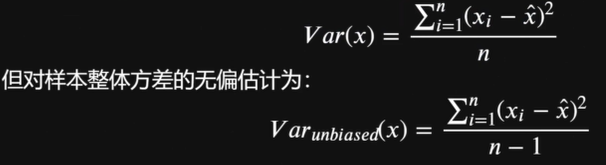

In [13]:
# 无偏估计计算结果
(f - torch.mean(f,0)) / torch.sqrt(torch.var(f,0,unbiased=False))

tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]])

注，torch.var中可通过设置unbiased参数来进行无偏估计的方差计算

当然，根据此前的介绍，BN层和线性层有许多类似的地方，这里我们可以查看BN层的参数情况。

In [14]:
list(bn1.parameters())

[Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True)]

据此也可确认在迭代开始之前，y和的的初始值。同时，根据参数的可微性，我们也能看出其最终也是需要通过反向传播计算梯度，然后利用梯度下降进行求解的。当然，此处如果我们将affine参数设置为False，则无法查看参数，并且归一化过程就是简单的在无偏估计下对数据进行Z-Score归一化。

In [15]:
bn2 = nn.BatchNorm1d(3,affine=False)

In [16]:
list(bn2.parametersa())  # 此时无法查看bn2参数

AttributeError: 'BatchNorm1d' object has no attribute 'parametersa'

In [18]:
bn2(f)  # 处理后的数据也不是可微的，无法进行反向传播，因此也无法修改BN参数

tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]])

<li> 训练数据均值与方差的迭代计算

&emsp;&emsp;对于BN层来说，计算过程并不复杂，但有一个核心需要解决的问题: 在测试阶段、针对可能出现的条条测试集输入的情况，应该如何对测试数据进行归一化处理。

&emsp;&emsp;针对此问题，BN层采用了机器学习一以贯之的基本思路，那就是所有用于处理测试数据的参数都在训练数据中得出，包括归一所需要用到的均值和方差，并且对于测试集在归一化过程中所用到的均值和方差，都是训练数据整体均值和方差。但是，在模型训练阶段，数据是分一个个小批输入的，而针对小批训练数据的归一化处理也没有采用所有训练数据的均值和方差，而是采用训练数据总体均值和方差的无偏估计带入进行计算。

    值得注意的是，针对测试集计算的均值和方差就是真实计算出的训练数据的均值和方差，而不是一个估计的结果

为了能够获取训练数据整体均值和方差BN采用了迭代累计计算的方法，通过类似动量法的方法对每一个小批数据的均值和方差进行累计统计，最终计算训练数据整体均值和方差，具体过程如下。

In [20]:
f = torch.arange(9).reshape(3,3).float()
f

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [21]:
bn1 = nn.BatchNorm1d(3)

In [23]:
bn1(f)

tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]], grad_fn=<NativeBatchNormBackward0>)

BN层在每一次进行归一化时，都会通过“某种”方法累计输入数据集的均值和方差，在每一次处理完批数据之后，我们都可以通过调用BN层的running_mean和running_var查看BN层所累计的均值和方差结果:

In [25]:
bn1.running_mean # 均值
bn1.running_var  # 方差

tensor([0.3000, 0.4000, 0.5000])

tensor([1.8000, 1.8000, 1.8000])

不过值得注意的是，BN层并不是记录输入数据集的均值和方差，而是采用了一种类似动量法的方法在累计每一个小批数据的统计量。这种累计过程如下:首先，当我们每次实例化一个BN层之后，都会获得一组原始的running_mean和running_var

In [27]:
bn2 = nn.BatchNorm1d(3)
bn2.running_mean # 均值
bn2.running_var  # 方差

tensor([0., 0., 0.])

tensor([1., 1., 1.])

初始条件下，running_mean取值为0,running_var取值为1。而当我们在使用BN层进行每一次归一化数据时，BN层的running_mean和running_var将按照如下公式进行调整:

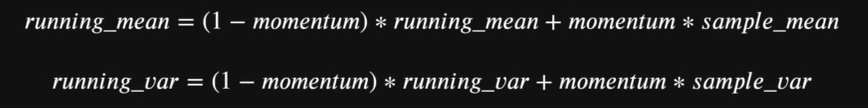

其中,<b>momentum是BN层实例化过程中的可选参数</b>,默认值为0.1,<b>sample表示当前输入的小批数据。</b>上述过程可简单理解为BN层每每次归一化一批数据,都会针对围绕已经记录running_mean/var和小批数据的sample_mean/var进行加权求和,在momentum取值为0.1的情况下,原running_mean/var权重是sample_mean/var的九倍,也就是说,当前数据归一化完成后，running_mean/var会朝向着sample_mean/var小幅移动。

例如，bn2迭代一轮(训练一批数据)后，bn2的running_mean/var取值结果如下:

In [28]:
bn2(f)

tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]], grad_fn=<NativeBatchNormBackward0>)

In [29]:
bn2.running_mean
bn2.running_var

tensor([0.3000, 0.4000, 0.5000])

tensor([1.8000, 1.8000, 1.8000])

In [30]:
bn3 = nn.BatchNorm1d(3)

In [32]:
bn3.running_mean*0.9 + 0.1 * torch.mean(f,0)

tensor([0.3000, 0.4000, 0.5000])

In [33]:
bn3.running_var*0.9 + 0.1 * torch.var(f,0)

tensor([1.8000, 1.8000, 1.8000])

##  model.train()与model.eval()

<li> 伴随向前传播调整running_mean/var

尽管BN找到了能够计算训练集整体均值和方差的方法，但截至目前，还是没有解决如何将在训练过程中记录的running_mean/var应用到测试集当中的方法。核心原因在于，BN层的running_mean/var是伴随向前传播同步调整的。也就是说，在track_running_stats开启时，只要进行一次向前传播，就会更新一次running_mean/var，这明显是不合适的 (因为我们不能根据测试集数据修改参数)。但是我们也知道，只要要进行测试集的测试，就一定需要模型执行测试数据的向前传播以得出模型结果，此时应该怎么办呢?

此前我们没有遇到该难题的主要原因是，线性层的参数调整是通过optimizer.step0完成的也就是说我们需要手动输入代码才能完成线性层参数调整，在模型训练过程，我们每一次迭代都会手动调整一次线性层参数，而在输入测试数据时我们只会执行向前传播，并不会在向前传播结束后进行optimizer.step0，因此输入测试数据不会影响模型参数调整

<li> model.train()与 model.eval()

此时就要用到PyTorch中适用于nn模块中所有模型的一种方法model.trai()与model.eval()。其model.train表示开启模型训练模式，在默认情况下，我们实例化的每一个模型都是出于训练模式的，而model.eval0则表示将模型转化为测试模式。我们可以简单查看该方法的相关说明.

In [35]:
bn5 = nn.BatchNorm1d(3)

In [36]:
bn5.train()

BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

当然，开始训练模式时参数取值为False则代表开启测试模式，即bn5.train(False)和bn5.eval0等效。

那么，训练模式和测试模式的根本区别是什么? 简单来说就是，在PyTorch中，其实有很多类似BN类四一样，会在向前传播过程中直接自动修改模型参数，而当模型出于测试模式时，会避免这种情况发生，模型出于测试模式时不会根据当前输入数据情况调整running_mean/var。并且，模型出于测试模式时，BN层会利用已经记录下的running_mean/var对数据进行归一化。

在PyTorch中，训练模式和测试模式的区分，相当于是给模型提供了可设置的两种行为模

In [37]:
f

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [45]:
bn5 = nn.BatchNorm1d(3)
bn5.train() # 进入训练模式
bn5.running_mean
bn5.running_var

BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

tensor([0., 0., 0.])

tensor([1., 1., 1.])

In [46]:
bn5(f) # 对输入数据的统计量进行无偏估计h

tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]], grad_fn=<NativeBatchNormBackward0>)

In [47]:
bn5.running_mean  # 并且更新记录的统计结果
bn5.running_var

tensor([0.3000, 0.4000, 0.5000])

tensor([1.8000, 1.8000, 1.8000])

In [49]:
bn5 = nn.BatchNorm1d(3)
bn5.eval()               # 进入测试模式
bn5.running_mean
bn5.running_var

BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

tensor([0., 0., 0.])

tensor([1., 1., 1.])

In [51]:
bn5(f)

tensor([[0.0000, 1.0000, 2.0000],
        [3.0000, 4.0000, 5.0000],
        [6.0000, 7.0000, 8.0000]], grad_fn=<NativeBatchNormBackward0>)

注意该结果的解读，此时是以running_mean/var作为均值和方差对数据集进行归一化处理，并且，此时的y和B分别是1和0。

In [52]:
list(bn5.parameters())

[Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True)]

因此最终处理结果还是原始数据本身。另外，在测试模式下，BN层也不会再记录running_mean/var。

In [53]:
bn5.running_mean
bn5.running_var

tensor([0., 0., 0.])

tensor([1., 1., 1.])

当然，对于一个模型，我们也可通过.training属性来查看模型处于训练模式还是测试模式。

In [71]:
bn5.training

False

    另外我们需要知道，当模型(model)由多个模块 (module)共同集成时，各模块的状态由模型整体状态决定。

# 利用nn.BatchNorm构建带BN的神经网络 

有了对nn.BatchNorm类基本了解之后，我们来尝试构建带有BN层的神经网络模型。根据上一节的介绍，我们知道BN本质上是一种自适应的数据分布调整算法，同时我们也知道，数据分布的调整并不影响因此我们可以在任何需要的位置都进行BN归一化。另外，根据Glorot条件，我们知道在模型构建过程中需要力求各梯度计算的有效性和平稳性，因此我们可以考虑在每一个线性层前面或者后面进行数据归一化处理。

在实际模型构建过程中，在模型中添加BN层和添加线性层类似，我们只需要在自定义模型类的init方法中添加BN层，并在向前传播方法中确定BN层的调用方法即可。而在具体BN层位置选择方面，是放在线性层前面还是放在线性层后面，目前业内没有定论，既没有理论论证BN层的最佳位置，也没有严谨的实验证明在哪个位置放置BN层效果最好。因此我们大可根据自己的习惯，以及自身经验的判断选择BN层的位置。当然，为了实验方便，我们会同时创建可以前置或者后置BN层的模型。(这里我们将放在隐藏层前面(也就是线性层后面)称为BN层前置，放在隐藏层后面称为BN层后置。)

## 构建模型类 

接下来，我们创建一个同时能够调整激活函数、可选是否包含BN层、以及BN层放置位置的模型，当然，该模型仍然是分层创建，在包含了上述参数后相当于此前模型的一个集成。我们先从简单入手，创建一个两层神经网络、BN层可选、激活函数可选的模型

In [5]:
class net_class1(nn.Module):
    def __init__(self, act_fun=torch.relu, in_features=2, n_hidden=4, out_features=1,bias=True, BN_model=None, momentum=0.1):
        super().__init__()
        self.linear1 = nn.Linear(in_features,n_hidden,bias=bias)
        self.normalize1 = nn.BatchNorm1d(n_hidden,momentum=momentum)
        self.linear2 = nn.Linear(n_hidden,out_features,bias=bias)
        self.BN_model = BN_model
        self.act_fun = act_fun
    def forward(self, x):
        if self.BN_model == None:
            z1 = self.linear1(x)
            p1 = self.act_fun(z1)
            out = self.linear2(p1)
        elif self.BN_model == 'pre':
            z1 = self.normalize1(self.linear1(x))
            p1 = self.act_fun(z1)
            out = self.linear2(p1)
        elif self.BN_model == 'post':
            z1 = self.linear1(x)
            p1 = self.act_fun(z1)
            out = self.linear2(self.normalize1(p1))
        return out

接下来，我们尝试调用此前的fit函数来进行模型训练。注意，此处开始我们将显式注明模型的训练和测试阶段。

In [105]:
# 设置随机数种子
torch.manual_seed(420)

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w = [2,-1], bias = False, deg = 2)

# 初始化核心参数
lr = 0.03
num_epochs = 20

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features,labels)

In [106]:
# 实例化一个前置BN层的神经网络
torch.manual_seed(24)
relu_model1_norm = net_class1(BN_model='pre')

In [107]:
# 设置模型为训练模式
relu_model1_norm.train()

net_class1(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (normalize1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

<b>这里我们只需要对模型整体进行训练模式设置，模型中所有模块都将调整为训练模式.

In [67]:
list(relu_model1_norm.modules())

[net_class1(
   (linear1): Linear(in_features=2, out_features=4, bias=True)
   (normalize1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (linear2): Linear(in_features=4, out_features=1, bias=True)
 ),
 Linear(in_features=2, out_features=4, bias=True),
 BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=4, out_features=1, bias=True)]

In [69]:
for m in list(relu_model1_norm.modules()):
    print(m.training == True)

True
True
True
True


In [72]:
relu_model1_norm.eval()

net_class1(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (normalize1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [86]:
for m in list(relu_model1_norm.modules()):
    print(m.training == True)

True
True
True
True


为了后续验证训练模式和测试模式是否生效，此处我们可以查看模型BN层的running_mean/var，BN层是模型的第二个模块。

In [87]:
list(relu_model1_norm.modules())[2]

BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

索引值为0返回的是整体模型，索引值为1返回第一层，索引值为2返回第二层，BN为第二层此处索引值为2

In [88]:
list(relu_model1_norm.modules())[2].running_mean
list(relu_model1_norm.modules())[2].running_var

tensor([-0.0009, -0.0514,  0.0013,  0.0157])

tensor([0.9113, 0.9274, 0.9353, 0.9260])

值得注意的是，此时BN层记录的均值和方差都有4个分量，而原始训练数据只有两个特征。本质上是因为此时BN层是围绕第一个线性层的输出结果进行归一化处理，而数据经过第一个线性层时将转化为N*4的形状

当然，我们也可查看当前BN层的参数情况

In [89]:
list(relu_model1_norm.modules())[2].weight
list(relu_model1_norm.modules())[2].bias

Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)

Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)

注意，当我们调用BN层的模块来查看参数时，weight就是γ，bias就是β。

接下来即可开始进行模型训练

In [108]:
fit(net=relu_model1_norm
   ,criterion=nn.MSELoss()
   ,optimizer=optim.SGD(relu_model1_norm.parameters(),lr=lr)
   ,batchdata=train_loader
   ,epochs=20
   ,cla=False)

重点查看BN层变化情况

In [109]:
list(relu_model1_norm.modules())[2].weight
list(relu_model1_norm.modules())[2].bias

Parameter containing:
tensor([2.0457, 2.8368, 3.2382, 2.0761], requires_grad=True)

Parameter containing:
tensor([-1.7242, -1.4776, -2.0089, -1.4371], requires_grad=True)

我们发现BN层确实得到了训练。当然，我们也可以查看BN层记录的统计指标

In [110]:
list(relu_model1_norm.modules())[2].running_mean
list(relu_model1_norm.modules())[2].running_var

tensor([-0.1294, -0.2738, -0.1332,  0.0668])

tensor([4.4674, 6.4921, 7.3547, 4.8549])

从BN层的记录结果来看，隐藏层输入的数据基本是零均值的，从侧面也证明了BN调整效果的有效性。
接下来我们将模型调整为测试模式，测试模型在训练集和测试集上的表现

In [111]:
relu_model1_norm.eval()

net_class1(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (normalize1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [112]:
mse_cal(train_loader,relu_model1_norm)

tensor(0.5253, grad_fn=<MseLossBackward0>)

In [113]:
mse_cal(test_loader,relu_model1_norm)

tensor(0.9437, grad_fn=<MseLossBackward0>)

观察running_mean和running_var的取值变化情况，判断测试模式是否生效

In [114]:
list(relu_model1_norm.modules())[2].weight
list(relu_model1_norm.modules())[2].bias
list(relu_model1_norm.modules())[2].running_mean
list(relu_model1_norm.modules())[2].running_var

Parameter containing:
tensor([2.0457, 2.8368, 3.2382, 2.0761], requires_grad=True)

Parameter containing:
tensor([-1.7242, -1.4776, -2.0089, -1.4371], requires_grad=True)

tensor([-0.1294, -0.2738, -0.1332,  0.0668])

tensor([4.4674, 6.4921, 7.3547, 4.8549])

至此，我们就完成了带BN的模型从训练到测试的全流程。当然，为了方便后续直接使用带BN层或者其他需要灵活调整训练模式和测试模式的其他方法，我们将模型模式调整也集成到此前定义的model_train_test和model_comparison函数中。

In [116]:
def model_train_test(model,train_data,test_data,num_epochs = 20,criterion=nn.MSELoss(),optimizer=optim.SGD,lr=0.03,cla=False,eva=mse_cal):
    '''
    模型误差测试函数：
    :param mode1: 模型
    :param train_data: 训练数据
    :param test data: 测试数据
    :param num_epochs: 选代轮数损失函数
    :param criterion: 损失函数
    :param lr: 学习率
    :param cla: 是否为分类模型
    :return: MSE列表
    
    '''
    # 模型评估指标矩阵
    train_l = []
    test_l = []
    
    # 模型训练过程
    for epochs in range(num_epochs):
        model.train()
        fit(net=model
            ,criterion=criterion
            ,optimizer=optimizer(model.parameters(),lr=lr)
            ,batchdata=train_data
            ,epochs=epochs
            ,cla=cla)
        model.eval()
        train_l.append(eva(train_data,model).detach())
        test_l.append(eva(test_data,model).detach())
    return train_l,test_l

In [117]:
def model_comparison(model_l, name_l, train_data, test_data, num_epochs=20, criterion=nn.MSELoss(), optimizer=optim.SGD, lr=0.03, cla=False, eva=mse_cal):
    '''
    模型对比函数：
    :param model_1:模型序列
    :param name_1:模型名称序列
    :param train_data: 训练数据
    :param test_data: 测试数据
    :param num_epochs: 迭代轮数
    :param criterion: 损失函数
    :param 1r: 学习率
    :param cla: 是否是分类模型
    :param eva: 模型评估指标
    :return: MSE张量矩阵
    '''
    # 模型评估指标矩阵
    train_l = torch.zeros(len(model_l),num_epochs)
    test_l = torch.zeros(len(model_l),num_epochs)
    
    # 模型训练过程
    for epochs in range(num_epochs):
        for i,model in enumerate(model_l):
            model.train()
            fit(net=model
               ,criterion=criterion
               ,optimizer=optimizer(model.parameters(),lr=lr)
               ,batchdata=train_data
               ,epochs=epochs
               ,cla=cla)
            model.eval()
            train_l[i][epochs] = eva(train_data,model).detach()
            test_l[i][epochs] = eva(test_data,model).detach()
    return train_l,test_l

##  带BN层的神经网络使用方法

接下来，我们简单尝试在自己生成的数据集上使用带BN层的模型

In [1]:
# 设置随机数种子
torch.manual_seed(420)

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w = [2,-1], bias = False, deg = 2)

# 初始化核心参数
lr = 0.03
num_epochs = 20

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features,labels)

我们先尝试使用sigmoid激活函数

In [7]:
# 实例化一个前置BN层的神经网络
torch.manual_seed(24)

# 实例化模型
sigmoid_model1 = net_class1(act_fun = torch.sigmoid)
sigmoid_model1_norm = net_class1(act_fun = torch.sigmoid,BN_model = 'pre')

# 创建模型容器
model_l = [sigmoid_model1,sigmoid_model1_norm]
name_l = ['sigmoid_model1','sigmoid_model1_norm']

# 核心参数
lr = 0.03
num_epochs = 40

# 模型训练
train_l,test_l = model_comparison(model_l=model_l
                                 ,name_l=name_l
                                 ,train_data=train_loader
                                 ,test_data=test_loader
                                 ,num_epochs=num_epochs
                                 ,criterion=nn.MSELoss()
                                 ,optimizer=optim.SGD
                                 ,lr=lr
                                 ,cla=False
                                 ,eva=mse_cal)

Text(0.5, 1.0, 'mse_train')

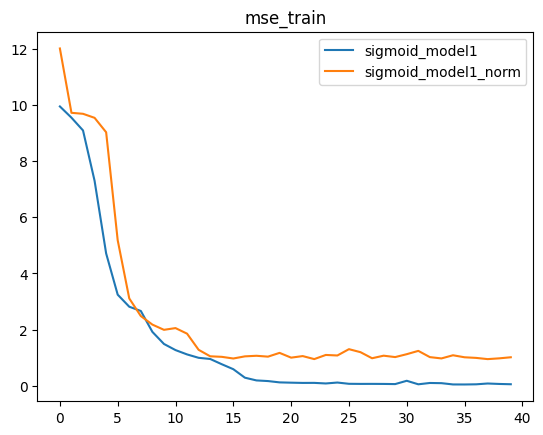

In [9]:
# 训练误差
for i,name in enumerate(name_l):
    plt.plot(list(range(num_epochs)),train_l[i],label=name)
plt.legend(loc=1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_test')

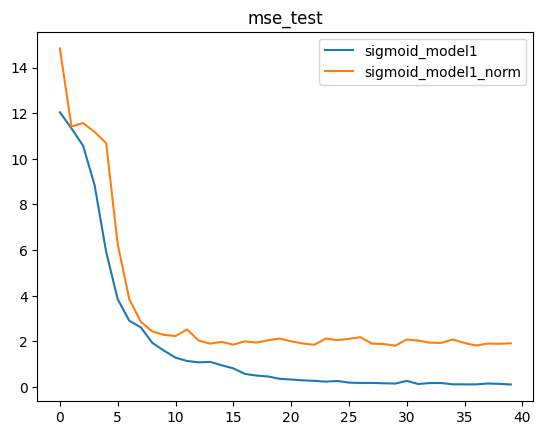

In [10]:
# 测试误差
for i,name in enumerate(name_l):
    plt.plot(list(range(num_epochs)),test_l[i],label=name)
plt.legend(loc=1)
plt.title('mse_test')

至此，我们就完成了一个完整的从构建带BN层的模型到建模输出结果并进行评估的全过程，但是我们发现，加入BN层之后，模型效果反而不如原始模型。不难发现，BN优化算法使用起来其实并不简单，并不是只要加入BN层模型效果就一定会有所提升。要充分发挥BN层的效果，需要结合其他模型参数进行综合调参。由于针对带BN层的模型调参将涉及到非常多其他优化方法的联合调参，因此我们将放在下一节统进行介绍。

当然，为了为下一节做准备，我们仿造net _class1继续编写拥有两个隐藏层、三个隐藏层和四个隐藏层的对应模型类。

In [1]:
class net_class2(nn.Module):
    def __init__(self, act_fun=torch.relu, in_features=2, n_hidden1=4, n_hidden2=4, out_features=1, bias=True, BN_model=None, momentum=0.1):
        super(net_class2, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden1, bias=bias)
        self.normalize1 = nn.BatchNorm1d(n_hidden1, momentum=momentum)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2, bias=bias)
        self.normalize2 = nn.BatchNorm1d(n_hidden2, momentum=momentum)
        self.linear3 = nn.Linear(n_hidden2, out_features, bias=bias)
        self.BN_model = BN_model
        self.act_fun = act_fun

    def forward(self, x):
        if self.BN_model is None:
            z1 = self.linear1(x)
            p1 = self.act_fun(z1)
            z2 = self.linear2(p1)
            p2 = self.act_fun(z2)
            out = self.linear3(p2)
        elif self.BN_model == 'pre':
            z1 = self.normalize1(self.linear1(x))
            p1 = self.act_fun(z1)
            z2 = self.normalize2(self.linear2(p1))
            p2 = self.act_fun(z2)
            out = self.linear3(p2)
        elif self.BN_model == 'post':
            z1 = self.linear1(x)
            p1 = self.act_fun(z1)
            z2 = self.linear2(self.normalize1(p1))
            p2 = self.act_fun(z2)
            out = self.linear3(self.normalize2(p2))
        return out


In [2]:
class net_class3(nn.Module):
    def __init__(self, act_fun=torch.relu, in_features=2, n_hidden1=4, n_hidden2=4, n_hidden3=4, out_features=1, bias=True, BN_model=None, momentum=0.1):
        super(net_class3, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden1, bias=bias)
        self.normalize1 = nn.BatchNorm1d(n_hidden1, momentum=momentum)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2, bias=bias)
        self.normalize2 = nn.BatchNorm1d(n_hidden2, momentum=momentum)
        self.linear3 = nn.Linear(n_hidden2, n_hidden3, bias=bias)
        self.normalize3 = nn.BatchNorm1d(n_hidden3, momentum=momentum)
        self.linear4 = nn.Linear(n_hidden3, out_features, bias=bias)
        self.BN_model = BN_model
        self.act_fun = act_fun

    def forward(self, x):
        if self.BN_model is None:
            z1 = self.linear1(x)
            p1 = self.act_fun(z1)
            z2 = self.linear2(p1)
            p2 = self.act_fun(z2)
            z3 = self.linear3(p2)
            p3 = self.act_fun(z3)
            out = self.linear4(p3)
        elif self.BN_model == 'pre':
            z1 = self.normalize1(self.linear1(x))
            p1 = self.act_fun(z1)
            z2 = self.normalize2(self.linear2(p1))
            p2 = self.act_fun(z2)
            z3 = self.normalize3(self.linear3(p2))
            p3 = self.act_fun(z3)
            out = self.linear4(p3)
        elif self.BN_model == 'post':
            z1 = self.linear1(x)
            p1 = self.act_fun(z1)
            z2 = self.linear2(self.normalize1(p1))
            p2 = self.act_fun(z2)
            z3 = self.linear3(self.normalize2(p2))
            p3 = self.act_fun(z3)
            out = self.linear4(self.normalize3(p3))
        return out

In [3]:
class net_class4(nn.Module):
    def __init__(self, act_fun=torch.relu, in_features=2, n_hidden1=4, n_hidden2=4, n_hidden3=4, n_hidden4=4, out_features=1, bias=True, BN_model=None, momentum=0.1):
        super(net_class4, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden1, bias=bias)
        self.normalize1 = nn.BatchNorm1d(n_hidden1, momentum=momentum)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2, bias=bias)
        self.normalize2 = nn.BatchNorm1d(n_hidden2, momentum=momentum)
        self.linear3 = nn.Linear(n_hidden2, n_hidden3, bias=bias)
        self.normalize3 = nn.BatchNorm1d(n_hidden3, momentum=momentum)
        self.linear4 = nn.Linear(n_hidden3, n_hidden4, bias=bias)
        self.normalize4 = nn.BatchNorm1d(n_hidden4, momentum=momentum)
        self.linear5 = nn.Linear(n_hidden4, out_features, bias=bias)
        self.BN_model = BN_model
        self.act_fun = act_fun

    def forward(self, x):
        if self.BN_model is None:
            z1 = self.linear1(x)
            p1 = self.act_fun(z1)
            z2 = self.linear2(p1)
            p2 = self.act_fun(z2)
            z3 = self.linear3(p2)
            p3 = self.act_fun(z3)
            z4 = self.linear4(p3)
            p4 = self.act_fun(z4)
            out = self.linear5(p4)
        elif self.BN_model == 'pre':
            z1 = self.normalize1(self.linear1(x))
            p1 = self.act_fun(z1)
            z2 = self.normalize2(self.linear2(p1))
            p2 = self.act_fun(z2)
            z3 = self.normalize3(self.linear3(p2))
            p3 = self.act_fun(z3)
            z4 = self.normalize4(self.linear4(p3))
            p4 = self.act_fun(z4)
            out = self.linear5(p4)
        elif self.BN_model == 'post':
            z1 = self.linear1(x)
            p1 = self.act_fun(z1)
            z2 = self.linear2(self.normalize1(p1))
            p2 = self.act_fun(z2)
            z3 = self.linear3(self.normalize2(p2))
            p3 = self.act_fun(z3)
            z4 = self.linear4(self.normalize3(p3))
            p4 = self.act_fun(z4)
            out = self.linear5(self.normalize4(p4))
        return out